In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [22]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [156]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1")

Best profile loss overall:
	Best run: 4
	Best epoch in run: 7
	Associated value: 85.01059447394476
Best epoch in each run:
	Run 1, epoch 10:  85.27
	Run 2, epoch 9:  85.25
	Run 3, epoch 9:  85.58
	Run 4, epoch 7:  85.01
	Run 5, epoch 10:  85.17
	Run 6, epoch 9:  85.33
	Run 7, epoch 9:  86.12
	Run 9, epoch 8:  85.12
All validation profile and prior losses:
1
	 91.07  86.55  85.92  85.63  85.47  85.35  85.28  85.20  85.14  85.11
	 87.02  86.09  85.76  85.64  85.53  85.48  85.44  85.30  85.32  85.27
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	 92.38  86.69  86.07  85.79  85.58  85.45  85.33  85.26  85.23  85.19
	 87.60  86.29  85.86  85.66  85.46  85.37  85.34  85.26  85.25  85.31
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	 93.30  87.55  86.60  86.20  86.02  85.88  85.80  85.73  85.69  85.63
	 88.22  86.78  86.26  85.95  85.80  85.83  85.68  85.76  85.58  85.59
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.00

In [155]:
prior_vals = print_validation_profile_and_prior_losses("SPI1_mpprior")

Best profile loss overall:
	Best run: 2
	Best epoch in run: 9
	Associated value: 86.89301598866781
Best epoch in each run:
	Run 1, epoch 10:  87.08
	Run 2, epoch 9:  86.89
All validation profile and prior losses:
1
	 93.27  88.16  87.96  87.60  87.58  87.40  87.26  87.17  87.12  87.08
	 88.80  87.92  87.93  87.82  87.74  87.51  87.31  87.37  87.24  87.08
	0.9791 0.9072 0.8877 0.8663 0.8604 0.8639 0.8620 0.8589 0.8561 0.8606
2
	 92.92  87.95  87.82  87.65  87.47  87.44  87.27  87.26  87.22  87.23
	 87.39  87.11  87.36  87.21  87.00  86.98  87.10  86.94  86.89  87.19
	0.9697 0.8913 0.8724 0.8630 0.8637 0.8601 0.8575 0.8570 0.8576 0.8595


In [25]:
import matplotlib.pyplot as plt

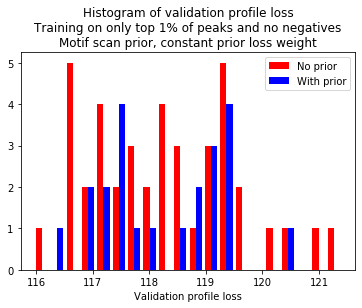

In [141]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only top 0.1% of peaks"
title += "\nMotif scan prior"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [73]:
import scipy.stats

In [111]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

0.15133081544424107
0.4406549880356912
